In [1]:
import random
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# ---- Tile Definition ----

class Tile:
    def __init__(self, north, east, south, west, name='T'):
        self.glues = {'N': north, 'E': east, 'S': south, 'W': west}
        self.name = name

    def get_glue(self, direction):
        return self.glues[direction]


# ---- Assembly Class ----

class AssemblyWithGlueInteractions:
    def __init__(self, tile_set):
        self.asmbDict = defaultdict(lambda: None)
        self.boundaryTiles = set()
        self.tile_set = tile_set
        self.seed_pos = (0, 0)
        self.asmbDict[self.seed_pos] = tile_set[0]
        self.update_boundary(self.seed_pos)

    def neighbor_positions(self, x, y):
        return {
            'N': (x, y + 1),
            'E': (x + 1, y),
            'S': (x, y - 1),
            'W': (x - 1, y)
        }

    def update_boundary(self, pos):
        x, y = pos
        for direction, (nx, ny) in self.neighbor_positions(x, y).items():
            if self.asmbDict[(nx, ny)] is None:
                self.boundaryTiles.add((nx, ny))
        if self.asmbDict[pos]:
            self.boundaryTiles.discard(pos)

    def glue_energy(self, g1, g2):
        return GLUE_INTERACTION[GLUE_INDEX[g1]][GLUE_INDEX[g2]]

    def local_energy(self, tile, x, y):
        energy = 0
        for direction, (nx, ny) in self.neighbor_positions(x, y).items():
            neighbor = self.asmbDict[(nx, ny)]
            g1 = tile.get_glue(direction)
            if neighbor:
                g2 = neighbor.get_glue({'N': 'S', 'S': 'N', 'E': 'W', 'W': 'E'}[direction])
                energy += self.glue_energy(g1, g2)
            else:
                energy += GLUE_BINDING_TO_FREE.get(g1, 0)
        return energy

    def grow_step(self):
        if not self.boundaryTiles:
            return

        (x, y) = random.choice(list(self.boundaryTiles))
        current_tile = self.asmbDict[(x, y)]

        # Attempt disconnection if tile exists
        if current_tile:
            energy_connected = self.local_energy(current_tile, x, y)
            deltaE = -energy_connected
            if deltaE < 0 or random.random() < math.exp(-deltaE / TEMPERATURE):
                self.asmbDict[(x, y)] = None
                self.boundaryTiles.add((x, y))
                return

        # Attempt attachment
        candidates = []
        weights = []
        for tile in self.tile_set:
            mu = chem_potentials[tile.name]
            energy = self.local_energy(tile, x, y)
            boltzmann_weight = math.exp(-(energy - mu) / TEMPERATURE)
            candidates.append(tile)
            weights.append(boltzmann_weight)

        total_weight = sum(weights)
        if total_weight == 0:
            return

        probabilities = [w / total_weight for w in weights]
        chosen_tile = random.choices(candidates, weights=probabilities, k=1)[0]
        self.asmbDict[(x, y)] = chosen_tile
        self.update_boundary((x, y))

    def grow(self, steps):
        for _ in range(steps):
            self.grow_step()



# ---- Plotting ----

def plot_assembly(assembly, tile_size=1.0):
    fig, ax = plt.subplots(figsize=(4, 4))
    for (x, y), tile in assembly.asmbDict.items():
        if tile:
            rect = patches.Rectangle((x * tile_size, y * tile_size),
                                     tile_size, tile_size,
                                     linewidth=1,
                                     edgecolor='black',
                                     facecolor=colorMap.get(tile.name, 'gray'))
            ax.add_patch(rect)
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_axis_off()
    # plt.grid(True)
    plt.show()





In [2]:
# ---- Configuration ----

TEMPERATURE = 0.1  # Thermal energy k_B T

# Glue types and interactions
GLUE_TYPES = ['A', 'B', 'C', 'D']
GLUE_INDEX = {g: i for i, g in enumerate(GLUE_TYPES)}

# Symmetric glue-glue interaction matrix
GLUE_INTERACTION = [
#   A    B    C    D
    [0.3, 0.0, 0.0, 0.0],  # A
    [0.0, 0.0, 0.0, 0.0],  # B
    [0.0, 0.0, 0.0, 0.0],  # C
    [0.0, 0.0, 0.0, 0.0],  # D
]

# Glue binding to free space
GLUE_BINDING_TO_FREE = {'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.0}

# Tile chemical potentials
chem_potentials = {"Seed": 0.0, "T1": 2.0, "T2": 0.0, "T3": 0.0, "T4": 0.0}

# Color map for plotting
colorMap = {"Seed": "red", "T1": "green", "T2": "blue", "T3": "yellow", "T4": "cyan"}


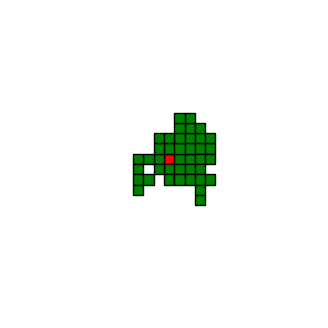

In [4]:
# ---- Tile Set ----

tiles = [
    Tile('A', 'A', 'A', 'A', name='Seed'),  # seed
    Tile('A', 'A', 'A', 'A', name='T1'),    # growth tile
    Tile('B', 'B', 'B', 'B', name='T2'),    # blocked
    Tile('C', 'C', 'C', 'C', name='T3'),    # blocked
    Tile('D', 'D', 'D', 'D', name='T4'),    # blocked
]


# ---- Run Simulation ----

glue_based_assembly = AssemblyWithGlueInteractions(tiles)
glue_based_assembly.grow(steps=40)
plot_assembly(glue_based_assembly, tile_size=1.0)
